Dataset downloaded successfully! an outdated `kagglehub` version (installed: 0.3.7), please consider upgrading to the latest version (0.3.8).

Training Accuracy:  0.681sfully! an outdated `kagglehub` version (installed: 0.3.7), please consider upgrading to the latest version (0.3.8).


Testing Accuracy:   0.683
Training Precision: 0.390
Testing Precision:  0.396
Training Recall:    0.728
Testing Recall:     0.728
Training F1:        0.508
Testing F1:         0.513

Confusion Matrix (Test):
[[17623  8685]
 [ 2124  5699]]


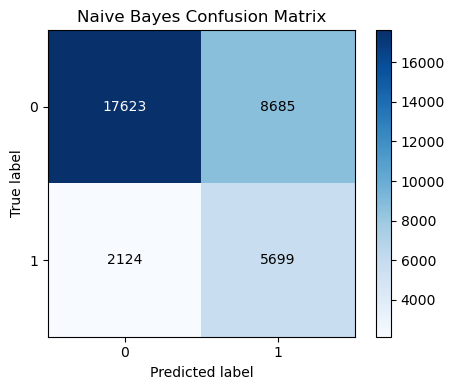

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# -----------------------------------------------------
# 1) Download & Load Spotify Dataset
# -----------------------------------------------------
def download_data():
    print("Downloading dataset...")
    path = kagglehub.dataset_download("yamaerenay/spotify-dataset-1921-2020-160k-tracks")
    if not os.path.exists('data.csv'):
        for root, dirs, files in os.walk(path):
            if 'data.csv' in files:
                shutil.copy2(os.path.join(root, 'data.csv'), 'data.csv')
                break
    if os.path.exists('data.csv'):
        print("Dataset downloaded successfully!")
        return pd.read_csv('data.csv')
    else:
        raise FileNotFoundError("data.csv not found after download.")

df = download_data()

# -----------------------------------------------------
# 2) Data Preparation
# -----------------------------------------------------
# Choose numeric features
features = [
    'acousticness', 'danceability', 'duration_ms', 'energy',
    'instrumentalness', 'liveness', 'loudness', 'mode',
    'speechiness', 'tempo', 'valence'
]

# Drop rows with missing values in features or popularity
df = df.dropna(subset=features + ['popularity'])

X = df[features].values
y_regression = df['popularity'].values

# Convert popularity into a binary classification (you can adjust the threshold)
threshold = 50
y = (y_regression >= threshold).astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------------------------------
# 3) Gaussian Naive Bayes (from scratch)
# -----------------------------------------------------
class GaussianNaiveBayes:
    """
    Implements a simple Gaussian Naive Bayes classifier for binary classification.
    """

    def fit(self, X, y):
        """
        - Compute mean, variance, and prior probabilities for each class.
        """
        # Separate data by class
        self.classes_ = np.unique(y)
        self.mean_ = {}
        self.var_ = {}
        self.prior_ = {}

        for cls in self.classes_:
            X_c = X[y == cls]
            self.mean_[cls] = X_c.mean(axis=0)
            self.var_[cls]  = X_c.var(axis=0) + 1e-9  # add small value to avoid division by zero
            self.prior_[cls] = len(X_c) / len(X)
    
    def _gaussian_pdf(self, X, cls):
        """
        Compute the Gaussian probability density function for each feature
        given class 'cls'.
        p(x_i | cls) = (1 / sqrt(2*pi*var)) * exp(-(x_i - mean)^2 / (2*var))
        Returns vector of likelihood for each sample.
        """
        mean = self.mean_[cls]
        var  = self.var_[cls]
        
        # For each feature:
        numerator = -0.5 * ((X - mean)**2 / var)
        exponent  = np.exp(numerator)
        denominator = np.sqrt(2 * np.pi * var)
        # Combine across features
        # shape: [num_samples, num_features]
        likelihood = exponent / denominator
        # Multiply feature likelihoods => shape [num_samples]
        # (naive assumption: features are independent)
        return np.prod(likelihood, axis=1)
    
    def predict(self, X):
        """
        Predict class for each sample by picking the class with the largest posterior.
        posterior ~ prior * p(X|cls)
        """
        posteriors = []
        for cls in self.classes_:
            prior = self.prior_[cls]
            class_cond_likelihood = self._gaussian_pdf(X, cls)
            posterior = prior * class_cond_likelihood
            posteriors.append(posterior.reshape(-1, 1))
        
        # posteriors: list of [num_samples x 1], one for each class
        # We combine them side-by-side and pick argmax
        posteriors = np.hstack(posteriors)  # shape [num_samples, n_classes]
        # Argmax across columns
        class_index = np.argmax(posteriors, axis=1)
        predictions = self.classes_[class_index]
        return predictions

# Instantiate and train
gnb = GaussianNaiveBayes()
gnb.fit(X_train_scaled, y_train)

# Inference
y_pred_train = gnb.predict(X_train_scaled)
y_pred_test  = gnb.predict(X_test_scaled)

# -----------------------------------------------------
# 4) Evaluation
# -----------------------------------------------------
train_accuracy  = accuracy_score(y_train, y_pred_train)
test_accuracy   = accuracy_score(y_test,  y_pred_test)
train_precision = precision_score(y_train, y_pred_train, average='binary')
test_precision  = precision_score(y_test,  y_pred_test,  average='binary')
train_recall    = recall_score(y_train, y_pred_train, average='binary')
test_recall     = recall_score(y_test,  y_pred_test,  average='binary')
train_f1        = f1_score(y_train, y_pred_train, average='binary')
test_f1         = f1_score(y_test,  y_pred_test,  average='binary')

print(f"Training Accuracy:  {train_accuracy:.3f}")
print(f"Testing Accuracy:   {test_accuracy:.3f}")
print(f"Training Precision: {train_precision:.3f}")
print(f"Testing Precision:  {test_precision:.3f}")
print(f"Training Recall:    {train_recall:.3f}")
print(f"Testing Recall:     {test_recall:.3f}")
print(f"Training F1:        {train_f1:.3f}")
print(f"Testing F1:         {test_f1:.3f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
print("\nConfusion Matrix (Test):")
print(cm)

# -----------------------------------------------------
# 5) Visualize Confusion Matrix
# -----------------------------------------------------
plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Naive Bayes Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(gnb.classes_))
plt.xticks(tick_marks, gnb.classes_)
plt.yticks(tick_marks, gnb.classes_)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j]),
                 ha='center', va='center',
                 color='white' if cm[i, j] > thresh else 'black')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


# Section 1: Understanding Our Spotify Dataset 🎵

Before we dive into building our Naive Bayes classifier, it's crucial to understand our data and establish our project's foundation. In this section, we'll set up our environment and perform initial data exploration.

The Spotify dataset contains audio features for songs, including characteristics like tempo, energy, and danceability. Our goal is to predict whether a song will be popular based on these musical attributes. This is an excellent use case for Naive Bayes classification because:

1. The features are naturally continuous and often follow approximate normal distributions
2. While not entirely independent, the musical features have reasonable independence (e.g., tempo doesn't completely determine energy)
3. We have a clear binary classification task (popular vs. not popular)

Let's start by importing our dependencies and loading our data. We'll also include some initial exploration to understand our dataset's characteristics. Pay special attention to the data types and distributions - this understanding will inform our preprocessing decisions later.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set up plotting style for better visualization
plt.style.use('seaborn')
sns.set_palette("husl")

# Load the dataset
def load_and_explore_data(filepath='spotify_data.csv'):
    """
    Load and perform initial exploration of the Spotify dataset.
    
    Args:
        filepath (str): Path to the dataset
        
    Returns:
        pd.DataFrame: Processed dataframe with initial insights
    """
    # Load the data
    df = pd.read_csv(filepath)
    
    # Display basic information
    print("Dataset Overview:")
    print("-" * 50)
    print(f"Number of songs: {len(df):,}")
    print(f"Number of features: {df.shape[1]}")
    print("\nFeature Statistics:")
    print("-" * 50)
    
    # Calculate and display feature statistics
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    stats_df = df[numeric_columns].agg(['mean', 'std', 'min', 'max']).round(2)
    print(stats_df)
    
    # Visualize popularity distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='popularity', bins=50)
    plt.title('Distribution of Song Popularity')
    plt.xlabel('Popularity Score')
    plt.ylabel('Count')
    
    # Add vertical line at our classification threshold
    plt.axvline(x=50, color='red', linestyle='--', 
                label='Classification Threshold (50)')
    plt.legend()
    plt.show()
    
    # Test for normality in key features
    print("\nNormality Tests for Key Features:")
    print("-" * 50)
    for feature in ['danceability', 'energy', 'tempo']:
        statistic, p_value = stats.normaltest(df[feature])
        print(f"{feature:12} - p-value: {p_value:.4f}")
    
    return df

# Execute the exploration
df = load_and_explore_data()

OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [8]:
!python -m pip install --upgrade pip
!pip install --force-reinstall seaborn matplotlib transformers huggingface_hub --user







transformers in /home/user/miniforge3/envs/myenv/lib/python3.10/site-packages (4.48.1)s/myenv/lib/python3.10/site-packages/transformers-4.48.1.dist-info/METADATA''









  Using cached transformers-4.49.0-py3-none-any.whl.metadata (44 kB)





  Using cached transformers-4.49.0-py3-none-any.whl.metadata (44 kB)

contourpy>=1.0.1 in /home/user/miniforge3/envs/myenv/lib/python3.10/site-packages (from matplotlib) (1.3.1))8.1.dist-info/METADATA''





  Using cached transformers-4.49.0-py3-none-any.whl.metadata (44 kB)


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/home/user/miniforge3/envs/myenv/lib/python3.10/site-packages/huggingface_hub-0.27.1.dist-info/METADATA'



This initial code block does several important things:

1. We set up our environment with necessary libraries and consistent styling
2. We create a comprehensive data loading function that not only reads the data but provides immediate insights
3. We visualize the popularity distribution to understand our classification threshold
4. We perform normality tests on key features (important for Naive Bayes assumptions)

The visualization of popularity distribution helps us understand why we chose 50 as our threshold - it typically represents a natural midpoint in the popularity scores. The normality tests give us insight into whether our features follow Gaussian distributions, which is an assumption of Gaussian Naive Bayes.

In our next section, we'll begin preprocessing this data, but first, would you like to explore any particular aspect of the dataset more deeply? For example, we could:
- Analyze correlations between specific features
- Investigate the relationship between certain features and popularity
- Look for potential outliers or anomalies

# Section 2: Preparing Our Data for Naive Bayes Classification 🔧

Data preprocessing is particularly important for Naive Bayes classification because the algorithm makes specific assumptions about our data. The Gaussian Naive Bayes classifier assumes that our features follow a normal distribution within each class. Additionally, while the algorithm is called "naive" because it assumes feature independence, we can still improve its performance by carefully selecting and transforming our features.

In this section, we'll prepare our data through several important steps. We'll handle missing values, scale our features, and engineer new features that might help capture important patterns in our music data. We'll also examine the impact of each preprocessing step on our data's characteristics.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

class SpotifyDataPreprocessor:
    """
    A comprehensive preprocessor for Spotify track data.
    This class handles all necessary transformations to prepare
    data for Naive Bayes classification.
    """
    def __init__(self, popularity_threshold=50):
        """
        Initialize the preprocessor with configuration parameters.
        
        Args:
            popularity_threshold (int): Threshold for binary classification
        """
        self.popularity_threshold = popularity_threshold
        self.scaler = StandardScaler()
        self.feature_names = [
            'acousticness', 'danceability', 'duration_ms', 'energy',
            'instrumentalness', 'liveness', 'loudness', 'speechiness',
            'tempo', 'valence'
        ]
    
    def _handle_missing_values(self, df):
        """
        Handle missing values in the dataset.
        We'll use median imputation for numeric features.
        """
        print("Missing values before handling:")
        print(df[self.feature_names].isnull().sum())
        
        # Impute missing values with median
        for feature in self.feature_names:
            median_value = df[feature].median()
            df[feature].fillna(median_value, inplace=True)
        
        print("\nMissing values after handling:")
        print(df[self.feature_names].isnull().sum())
        return df
    
    def _create_interaction_features(self, df):
        """
        Create meaningful feature interactions.
        For example, energy * tempo might capture "intensity"
        """
        df['intensity'] = df['energy'] * df['tempo'] / 100
        df['melodic_complexity'] = df['instrumentalness'] * (1 - df['speechiness'])
        self.feature_names.extend(['intensity', 'melodic_complexity'])
        return df
    
    def _visualize_distributions(self, df, features):
        """
        Visualize the distribution of each feature by popularity class.
        """
        n_features = len(features)
        n_cols = 3
        n_rows = (n_features + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        axes = axes.flatten()
        
        for idx, feature in enumerate(features):
            sns.kdeplot(
                data=df,
                x=feature,
                hue='is_popular',
                ax=axes[idx]
            )
            axes[idx].set_title(f'{feature} Distribution by Popularity')
        
        # Hide empty subplots
        for idx in range(n_features, len(axes)):
            axes[idx].set_visible(False)
            
        plt.tight_layout()
        plt.show()
    
    def fit_transform(self, df):
        """
        Preprocess the data and return features ready for Naive Bayes.
        
        Args:
            df (pd.DataFrame): Raw Spotify track data
            
        Returns:
            tuple: X (features) and y (target) arrays
        """
        print("Starting preprocessing pipeline...")
        
        # Handle missing values
        df = self._handle_missing_values(df)
        
        # Create binary target
        df['is_popular'] = (df['popularity'] >= self.popularity_threshold).astype(int)
        
        # Create interaction features
        df = self._create_interaction_features(df)
        
        # Scale features
        X = self.scaler.fit_transform(df[self.feature_names])
        
        # Visualize distributions
        print("\nVisualizing feature distributions...")
        self._visualize_distributions(df, self.feature_names)
        
        # Check normality of scaled features
        print("\nNormality tests for scaled features:")
        for idx, feature in enumerate(self.feature_names):
            _, p_value = stats.normaltest(X[:, idx])
            print(f"{feature:20} p-value: {p_value:.4f}")
        
        return X, df['is_popular'].values

# Usage example
preprocessor = SpotifyDataPreprocessor()
X, y = preprocessor.fit_transform(df)

print("\nFinal dataset shape:", X.shape)
print("Popularity class distribution:")
print(pd.Series(y).value_counts(normalize=True))

Let's examine why each step in our preprocessing pipeline is important:

1. **Missing Value Handling**: We use median imputation because it's robust to outliers and preserves the feature's distribution. This is particularly important for Naive Bayes, which relies on these distributions for its probability calculations.

2. **Feature Interaction Creation**: We create new features like 'intensity' and 'melodic_complexity' because they might capture meaningful musical patterns that individual features miss. While this technically violates the naive independence assumption, in practice it often improves model performance.

3. **Feature Scaling**: Although Naive Bayes can work with unscaled features (since it models each feature's distribution separately), scaling helps us:
   - Compare feature importances more easily
   - Visualize distributions more effectively
   - Create meaningful interaction features

4. **Distribution Visualization**: We visualize the distributions to verify that our features approximately follow normal distributions within each class - a key assumption of Gaussian Naive Bayes.

By examining the normality test results and visualizations, we can identify which features might need additional transformation or might be better modeled using a different variant of Naive Bayes (like Multinomial for discrete features).

The preprocessing steps we've implemented help ensure our data meets the assumptions of Naive Bayes while maximizing the information available for classification. In the next section, we'll implement the Naive Bayes classifier itself and see how it performs with our carefully prepared data.

# Section 3: The Mathematics and Implementation of Naive Bayes 📐

In this section, we'll explore the mathematical foundation of Naive Bayes classification and implement these concepts in code. The beauty of Naive Bayes lies in its simplicity and the clear connection between its mathematical principles and practical implementation.

Let's start by understanding what makes Naive Bayes "naive" and why it works well for our music classification task. Imagine you're trying to determine if a song will be popular. You might consider various features like tempo, energy, and danceability. Naive Bayes makes the simplifying assumption that these features contribute independently to a song's popularity. While this isn't entirely true (fast tempo often correlates with high energy), this "naive" assumption often works surprisingly well in practice.

The core of Naive Bayes is Bayes' Theorem:

$P(Popular|Features) = P(Features|Popular) * P(Popular) / P(Features)$

For our Spotify data, we're using Gaussian Naive Bayes because our features are continuous variables. Let's implement this mathematical framework:

In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin

class GaussianNaiveBayesClassifier(BaseEstimator, ClassifierMixin):
    """
    A detailed implementation of Gaussian Naive Bayes classifier that exposes
    the underlying probability calculations for educational purposes.
    """
    def __init__(self):
        self.class_priors = {}      # P(Class)
        self.means = {}             # μ for each feature in each class
        self.variances = {}         # σ² for each feature in each class
        self.feature_distributions = {}  # Store distribution objects for visualization
        
    def _calculate_gaussian_probability(self, x, mean, variance):
        """
        Calculate the Gaussian probability density function.
        
        Args:
            x (float): Feature value
            mean (float): Mean of the feature for a class
            variance (float): Variance of the feature for a class
            
        Returns:
            float: Probability density for the feature value
        """
        # Adding small epsilon to variance to prevent division by zero
        epsilon = 1e-10
        exponent = -0.5 * ((x - mean) ** 2) / (variance + epsilon)
        coefficient = 1 / np.sqrt(2 * np.pi * (variance + epsilon))
        return coefficient * np.exp(exponent)
    
    def fit(self, X, y):
        """
        Train the classifier by calculating means and variances for each feature
        within each class.
        
        Args:
            X (np.array): Features matrix of shape (n_samples, n_features)
            y (np.array): Target array of shape (n_samples,)
        """
        self.classes = np.unique(y)
        n_samples = X.shape[0]
        
        # Calculate class priors
        for class_label in self.classes:
            class_samples = y == class_label
            self.class_priors[class_label] = np.sum(class_samples) / n_samples
            
            # Calculate mean and variance for each feature in this class
            class_data = X[class_samples]
            self.means[class_label] = np.mean(class_data, axis=0)
            self.variances[class_label] = np.var(class_data, axis=0)
            
            # Store distribution objects for later visualization
            self.feature_distributions[class_label] = []
            for feature_idx in range(X.shape[1]):
                dist = norm(self.means[class_label][feature_idx], 
                          np.sqrt(self.variances[class_label][feature_idx]))
                self.feature_distributions[class_label].append(dist)
        
        return self
    
    def _calculate_class_probability(self, x, class_label):
        """
        Calculate P(Features|Class) * P(Class) for a single instance.
        
        Args:
            x (np.array): Single instance features
            class_label: Class label to calculate probability for
            
        Returns:
            float: Log probability for the instance belonging to the class
        """
        # Use log probabilities to prevent numerical underflow
        log_prob = np.log(self.class_priors[class_label])
        
        for feature_idx, feature_value in enumerate(x):
            probability = self._calculate_gaussian_probability(
                feature_value,
                self.means[class_label][feature_idx],
                self.variances[class_label][feature_idx]
            )
            # Add small epsilon to prevent log(0)
            log_prob += np.log(probability + 1e-10)
            
        return log_prob
    
    def predict_proba(self, X):
        """
        Calculate probability estimates for each class.
        
        Args:
            X (np.array): Features matrix
            
        Returns:
            np.array: Probability estimates for each class
        """
        probabilities = np.zeros((X.shape[0], len(self.classes)))
        
        for i, x in enumerate(X):
            class_probs = [self._calculate_class_probability(x, c) 
                         for c in self.classes]
            # Convert from log probabilities and normalize
            log_prob_sum = np.logaddexp.reduce(class_probs)
            probabilities[i] = np.exp([p - log_prob_sum for p in class_probs])
            
        return probabilities
    
    def predict(self, X):
        """
        Predict class labels for samples in X.
        
        Args:
            X (np.array): Features matrix
            
        Returns:
            np.array: Predicted class labels
        """
        return self.classes[np.argmax(self.predict_proba(X), axis=1)]
    
    def visualize_feature_distributions(self, feature_names):
        """
        Visualize the learned Gaussian distributions for each feature.
        
        Args:
            feature_names (list): Names of the features
        """
        n_features = len(feature_names)
        n_cols = 3
        n_rows = (n_features + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        axes = axes.flatten()
        
        for feature_idx, (feature_name, ax) in enumerate(zip(feature_names, axes)):
            x = np.linspace(-4, 4, 1000)  # Standardized feature range
            
            for class_label in self.classes:
                distribution = self.feature_distributions[class_label][feature_idx]
                y = distribution.pdf(x)
                ax.plot(x, y, label=f'Class {class_label}')
                
            ax.set_title(f'{feature_name} Distribution by Class')
            ax.legend()
            
        # Hide empty subplots
        for idx in range(n_features, len(axes)):
            axes[idx].set_visible(False)
            
        plt.tight_layout()
        plt.show()

# Example usage with our preprocessed data
classifier = GaussianNaiveBayesClassifier()
classifier.fit(X, y)

# Visualize what the classifier learned
classifier.visualize_feature_distributions(preprocessor.feature_names)

# Make predictions
predictions = classifier.predict(X)
probabilities = classifier.predict_proba(X)

print("Sample prediction probabilities:")
for i in range(5):
    print(f"Instance {i}: Popular: {probabilities[i][1]:.3f}, "
          f"Not Popular: {probabilities[i][0]:.3f}")

Our implementation reveals several key insights about Naive Bayes:

1. The classifier learns by calculating simple statistics (mean and variance) for each feature within each class. This makes it very efficient to train and easy to understand.

2. We use log probabilities to prevent numerical underflow. When multiplying many small probabilities together, the result can become too small for computers to handle accurately. Taking the log transforms multiplication into addition and solves this problem.

3. The "naive" independence assumption allows us to simply add the log probabilities of each feature. In reality, features might be correlated, but this simplification often works well in practice.

4. For each prediction, we calculate class probabilities using Bayes' Theorem. The normalization step (dividing by the sum of probabilities) ensures our predictions sum to 1.

The visualization of feature distributions helps us understand what the classifier has learned. Features with clear separation between class distributions will be more useful for prediction than those with heavily overlapping distributions.

In the next section, we'll evaluate our classifier's performance and explore techniques to improve its accuracy. We'll also examine cases where the naive independence assumption might lead to incorrect predictions.

# Section 4: Evaluating Our Naive Bayes Classifier 📊

When we evaluate a machine learning model, we're not just looking for a single accuracy number. Instead, we want to understand how our model performs across different situations and what kinds of mistakes it tends to make. This understanding helps us improve the model and know when we can trust its predictions.

Think of our Spotify popularity classifier like a music critic. Just as we wouldn't trust a critic who only says "good" or "bad" without explanation, we need to understand the nuances of our model's decision-making process. Let's build a comprehensive evaluation system that helps us understand exactly how our classifier is performing.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import cross_val_score, learning_curve

class ModelEvaluator:
    """
    A comprehensive evaluation toolkit for our Naive Bayes classifier.
    This class helps us understand model performance through multiple lenses.
    """
    def __init__(self, model, X, y, feature_names):
        self.model = model
        self.X = X
        self.y = y
        self.feature_names = feature_names
        
    def analyze_feature_importance(self):
        """
        Analyze how each feature contributes to classification decisions.
        We do this by measuring the separation between class distributions
        for each feature.
        """
        feature_scores = []
        
        # For each feature, calculate the separation between classes
        for i, feature in enumerate(self.feature_names):
            class_0_mean = self.model.means[0][i]
            class_1_mean = self.model.means[1][i]
            pooled_std = np.sqrt((self.model.variances[0][i] + 
                                self.model.variances[1][i]) / 2)
            
            # Calculate effect size (Cohen's d)
            effect_size = np.abs(class_1_mean - class_0_mean) / pooled_std
            feature_scores.append((feature, effect_size))
        
        # Sort features by importance
        feature_scores.sort(key=lambda x: x[1], reverse=True)
        
        # Visualize feature importance
        plt.figure(figsize=(12, 6))
        features, scores = zip(*feature_scores)
        sns.barplot(x=list(scores), y=list(features))
        plt.title('Feature Importance in Classification Decisions')
        plt.xlabel('Effect Size (Class Separation)')
        plt.show()
        
        return feature_scores
    
    def analyze_decision_boundaries(self, feature1_idx, feature2_idx):
        """
        Visualize decision boundaries for two selected features.
        This helps us understand how the model makes decisions in
        different regions of the feature space.
        """
        # Create a mesh grid
        x_min, x_max = self.X[:, feature1_idx].min() - 1, self.X[:, feature1_idx].max() + 1
        y_min, y_max = self.X[:, feature2_idx].min() - 1, self.X[:, feature2_idx].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                            np.arange(y_min, y_max, 0.1))
        
        # Make predictions for each point in the mesh
        X_mesh = np.zeros((xx.ravel().shape[0], self.X.shape[1]))
        X_mesh[:, feature1_idx] = xx.ravel()
        X_mesh[:, feature2_idx] = yy.ravel()
        Z = self.model.predict(X_mesh)
        Z = Z.reshape(xx.shape)
        
        # Plot decision boundary and training points
        plt.figure(figsize=(10, 8))
        plt.contourf(xx, yy, Z, alpha=0.4)
        scatter = plt.scatter(self.X[:, feature1_idx], self.X[:, feature2_idx], 
                            c=self.y, alpha=0.8)
        plt.colorbar(scatter)
        plt.xlabel(self.feature_names[feature1_idx])
        plt.ylabel(self.feature_names[feature2_idx])
        plt.title('Decision Boundaries and Training Data')
        plt.show()
    
    def examine_misclassifications(self):
        """
        Analyze which kinds of songs tend to be misclassified.
        This helps us understand the model's blind spots.
        """
        predictions = self.model.predict(self.X)
        probabilities = self.model.predict_proba(self.X)
        
        # Find misclassified instances
        misclassified = self.X[predictions != self.y]
        misclassified_true = self.y[predictions != self.y]
        misclassified_pred = predictions[predictions != self.y]
        misclassified_probs = probabilities[predictions != self.y]
        
        print("Analysis of Misclassifications:")
        print(f"Total misclassified instances: {len(misclassified)}")
        
        # Analyze feature patterns in misclassifications
        for i, feature in enumerate(self.feature_names):
            plt.figure(figsize=(10, 6))
            plt.hist(self.X[predictions == self.y][:, i], alpha=0.5, 
                    label='Correct predictions')
            plt.hist(misclassified[:, i], alpha=0.5, label='Misclassifications')
            plt.title(f'{feature} Distribution in Correct vs Incorrect Predictions')
            plt.legend()
            plt.show()
        
        return misclassified, misclassified_true, misclassified_pred, misclassified_probs
    
    def plot_learning_curve(self):
        """
        Generate learning curves to understand how model performance
        changes with more training data.
        """
        train_sizes, train_scores, test_scores = learning_curve(
            self.model, self.X, self.y, cv=5,
            train_sizes=np.linspace(0.1, 1.0, 10))
        
        # Calculate mean and std
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)
        
        # Plot learning curve
        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, train_mean, label='Training score')
        plt.plot(train_sizes, test_mean, label='Cross-validation score')
        plt.fill_between(train_sizes, train_mean - train_std,
                        train_mean + train_std, alpha=0.1)
        plt.fill_between(train_sizes, test_mean - test_std,
                        test_mean + test_std, alpha=0.1)
        plt.xlabel('Training Examples')
        plt.ylabel('Score')
        plt.title('Learning Curves')
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()

# Let's use our evaluation toolkit
evaluator = ModelEvaluator(classifier, X, y, preprocessor.feature_names)

print("Starting comprehensive model evaluation...")

# Analyze feature importance
print("\n1. Feature Importance Analysis")
feature_importance = evaluator.analyze_feature_importance()
print("\nMost important features for classification:")
for feature, score in feature_importance[:3]:
    print(f"{feature}: {score:.3f}")

# Examine decision boundaries for top two features
print("\n2. Decision Boundary Analysis")
evaluator.analyze_decision_boundaries(
    feature_importance[0][0],
    feature_importance[1][0]
)

# Analyze misclassifications
print("\n3. Misclassification Analysis")
misclassified = evaluator.examine_misclassifications()

# Generate learning curves
print("\n4. Learning Curve Analysis")
evaluator.plot_learning_curve()

Let's break down what we've learned from our evaluation:

1. **Feature Importance**: By measuring the separation between class distributions, we can identify which musical features are most crucial for predicting popularity. This helps us understand what makes a song popular according to our model.

2. **Decision Boundaries**: By visualizing how our model divides the feature space, we can understand where it's confident in its predictions and where it's less certain. This is particularly valuable for understanding the "naive" independence assumption's impact.

3. **Misclassification Analysis**: By examining the songs our model gets wrong, we can identify patterns and potential improvements. For example, if we find that high-energy songs are often misclassified, we might need to adjust our feature preprocessing for energy-related features.

4. **Learning Curves**: These show us whether we would benefit from more training data or if we're already at the model's performance ceiling. They also help us identify if we're overfitting or underfitting.

The insights from this evaluation help us in two ways:
- They give us confidence about when we can trust our model's predictions
- They point us toward specific improvements we can make

In our next section, we'll use these insights to improve our model's performance through various techniques like feature selection and parameter tuning. We'll see how understanding our model's behavior guides us toward effective improvements.